In [36]:
import datasets
from datasets import load_dataset,Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator
from transformers import AutoModelForTokenClassification
import torch
from PIL import ImageDraw, ImageFont,Image


# self implement
from model.utils.dataProcessor import MyDataProcessor,Entities_list,id2label,label2id

#-------
# Macro args
#-------
BATCH_SIZE = 50
TRAIN_TEST_SPLIT_RATIO = 0.8
EPOCHS = 5
TRAIN_EN = True
EVAL_STEPS = 300

In [38]:
#-----------------
# prepare the dataset
#-----------------
if TRAIN_EN:
    dataset = load_dataset("model/utils/my_dataset.py",'en',data_dir='data')
else:
    dataset = load_dataset('model/utils/my_dataset.py','zh',data_dir='data')


processor = MyDataProcessor(train_en=True)# TODO: maybe a bug in huggingface code??? when i specify the language, there will be a bug

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),# the LayoutLMv3 processor output pixel_values to be (3,224,224) instead of (3,resized_size[0],resized_size[1])
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),# [168, 103, 550, 136]
    'labels': Sequence(feature=Value(dtype='int64')),# [-100, 1, -100, 2, 2, 0, 0, 0, -100, -100, -100, 0, 0, -100, ...]
})

encoding_dataset = dataset["train"].map(
    processor.process_example,
    batched=True,
    remove_columns=dataset["train"].column_names,
    features=features,
    batch_size=BATCH_SIZE
)

# import pickle
# # pickle.dump(encoding_dataset,open('encoding_dataset.pkl','wb'))
# encoding_dataset = pickle.load(open('encoding_dataset.pkl','rb'))

encoding_dataset.set_format("torch")

Using custom data configuration en-data_dir=data
Reusing dataset my_dataset (/home/ma-user/.cache/huggingface/datasets/my_dataset/en-data_dir=data/1.0.0/22c9b1aee19d2299ac7a3068f1d7405608bb097734adad510e427935b1147618)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [39]:
#-----------
# define the model
#-----------
ckpt_path='./model/saved'
en_model = AutoModelForTokenClassification.from_pretrained(ckpt_path+'/en/checkpoint-6340')
zh_model = AutoModelForTokenClassification.from_pretrained(ckpt_path+'/zh/checkpoint-2248')

In [42]:
example = dataset['train'][0]
encoding = encoding_dataset[:2] # ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels']

image_path = example['image_path']
boxes = example['bboxes']

image = Image.open(image_path).convert("RGB")

width = image.width
height = image.height

def viz(model):
    model.eval()
    with torch.no_grad():
        output = model(**encoding)# encoding至少包含两个，不然会报错
        logits = output.logits[0] # 只取第一个
        predictions = logits.argmax(-1).squeeze().tolist()
    true_predictions = [en_model.config.id2label[pred]  for pred, label in zip(predictions, encoding['labels'][0]) if label != - 100] # there is no difference between en and zh in id2label
    true_labels = [en_model.config.id2label[int(label)] for pred, label in zip(predictions, encoding['labels'][0]) if label != -100]
    true_boxes = [[box[0][0],box[0][1],box[2][0],box[2][1]] for box, label in zip(boxes, encoding['labels'][0]) if label != -100]

    draw = ImageDraw.Draw(image)

    font = ImageFont.load_default()

    label2color = {'I-company':'blue','B-company':'blue', 
                    'I-date':'green','B-date':'green',
                    'I-total':'orange','B-total':'orange', 
                    'I-tax':'red','B-tax':'red',
                    'I-name':'black','B-name':'black',
                    'I-cnt':'yellow','B-cnt':'yellow',
                    'I-price':'purple','B-price':'purple',
                    'O':'white'}

    for prediction, box in zip(true_labels, true_boxes):
        draw.rectangle(box, outline=label2color[prediction])
        # draw.rectangle(box)
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
        # draw.text((box[0] + 10, box[1] - 10), text=prediction, font=font)
viz(zh_model)

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


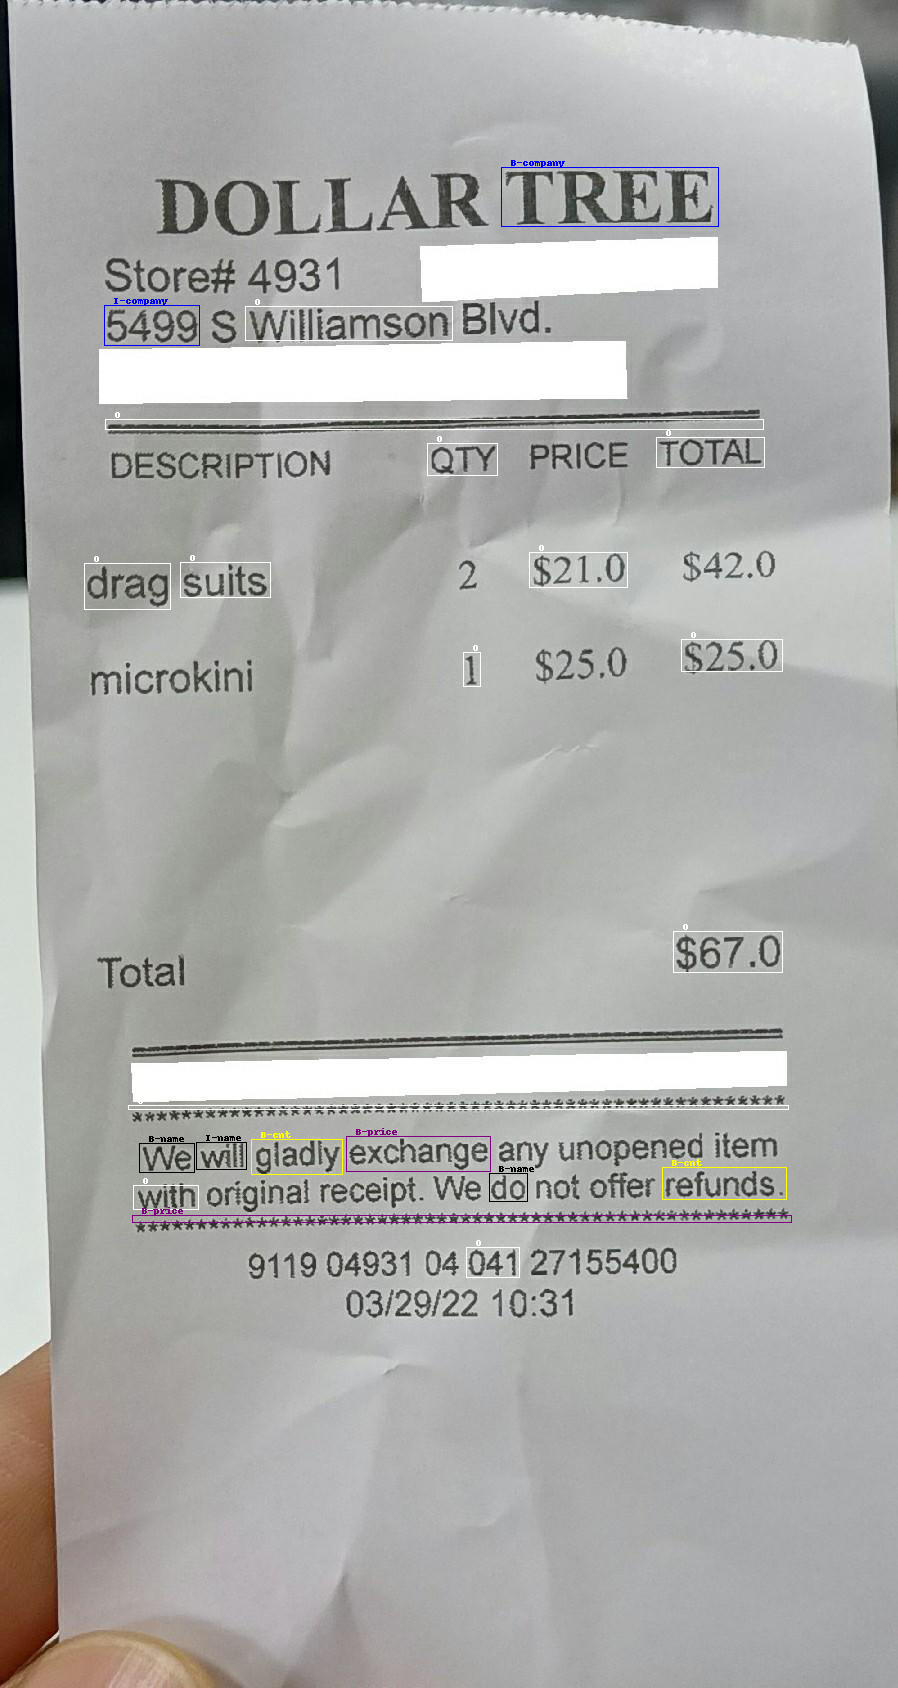

In [43]:
image